<a href="https://colab.research.google.com/github/NoobCoder-dweeb/AI-HandsOn-Journey/blob/main/notes/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q seaborn transformers accelerate evaluate huggingface_hub datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("hf://datasets/scikit-learn/imdb/IMDB Dataset.csv")

columns = df.columns
print(columns)

print(f"\nDF info:\n{df.info()}")

Index(['review', 'sentiment'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB

DF info:
None


In [5]:
df.head(10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [6]:
df.shape

(50000, 2)

# Using TF-IDF + KNN

In [7]:
from sklearn.model_selection import train_test_split

df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

X = df['review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

df_train = pd.concat([X_train, y_train], axis=1)

df_train.head()

,review,sentiment
47808,I caught this little gem totally by accident b...,1
20154,I can't believe that I let myself into this mo...,0
43069,*spoiler alert!* it just gets to me the nerve ...,0
19413,If there's one thing I've learnt from watching...,0
13673,"I remember when this was in theaters, reviews ...",0


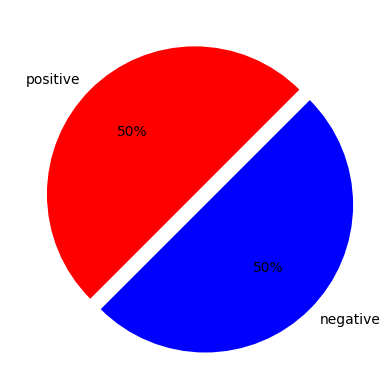

In [8]:
from sklearn.preprocessing import TargetEncoder

colors = ['red', 'blue']
pos = df_train[df_train['sentiment'] == 1]
neg = df_train[df_train['sentiment'] == 0]
ck = [pos['sentiment'].count(), neg['sentiment'].count()]

plt.pie(ck, labels=['positive', 'negative'], colors=colors, autopct='%.0f%%', explode=(0,0.1), startangle=45)
plt.show()
#

In [9]:
df_train['review']

,review
47808,I caught this little gem totally by accident b...
20154,I can't believe that I let myself into this mo...
43069,*spoiler alert!* it just gets to me the nerve ...
19413,If there's one thing I've learnt from watching...
13673,"I remember when this was in theaters, reviews ..."
...,...
31092,It's the 1920s. And a man named Walt Disney wa...
22917,"The first (and only) time I saw ""Shades"" was d..."
47481,This was such a waste of time. Danger: If you ...
35597,this is by far the most pathetic movie Indian ...


In [10]:
import re
def preprocess(text):
  text = text.lower()
  # text = text.replace('*', '')
  # text = text.replace('!', '')
  # text = text.replace('\'', '')
  # text = text.replace('(', '')
  # text = text.replace(')', '')
  # text = text.replace('<', '')
  # text = text.replace('>', '')
  # text = text.replace('.', '')
  # text = text.replace(',', '')
  # text = text.replace('"', '')
  # text = text.replace(':', '')
  # text = text.replace('/', '')
  text = re.sub(r"[*!'()<>.,\":/\[\]]", '', text)
  return text

df_train['prep_review'] = df_train['review'].apply(preprocess)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

count = CountVectorizer()
bag = count.fit_transform(df_train['prep_review'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
result = tfidf.fit_transform(df_train['prep_review'])

In [13]:
result.shape, y_train.shape

((40000, 134637), (40000,))

In [14]:
print("IDF values:")
for e1, e2 in zip(tfidf.get_feature_names_out(), tfidf.idf_):
  print(e1, ':', e2)

Streaming output truncated to the last 5000 lines.
watts : 7.985741820139354
waugh : 10.210365371663688
waughs : 10.903512552223633
wauters : 10.498047444115468
wave : 6.3981627015177525
wavebr : 10.210365371663688
waved : 9.804900263555524
wavelength : 9.399435155447359
wavelets : 10.903512552223633
wavepunk : 10.903512552223633
waver : 9.987221820349477
wavered : 9.650749583728265
waveredhe : 10.903512552223633
wavering : 9.111753082995579
waverley : 10.903512552223633
waverly : 9.517218191103742
wavers : 9.399435155447359
waverunner : 10.903512552223633
waves : 6.825975108317913
wavesbr : 10.498047444115468
waving : 7.704839434672952
wavingly : 10.903512552223633
wavy : 10.498047444115468
waw : 10.498047444115468
wawa : 10.903512552223633
wax : 7.042782841183038
waxany : 10.903512552223633
waxbr : 10.903512552223633
waxed : 10.498047444115468
waxes : 9.399435155447359
waxing : 9.031710375322042
waxman : 9.399435155447359
waxmans : 10.210365371663688
waxork : 10.903512552223633
waxth

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
X_train_, X_test_, y_train_, y_test_ = train_test_split(result, y_train, random_state=42, stratify=y_train)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_, y_train_)

y_pred = knn.predict(X_test_)

print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      5000
           1       0.74      0.83      0.78      5000

    accuracy                           0.77     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.77      0.77      0.77     10000



# Use LSTM

In [16]:
import torch
import torch.nn as nn
from torch.optim import Adam

class LSTM(nn.Module):
  def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
    """
    Initialises LSTM module and FC layer
    LSTM: process sequence
    FC: maps hidden state to output/produce the output
    """
    super(LSTM, self).__init__()
    self.hidden_dim = hidden_dim
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x, h0=None, c0=None):
    x = self.embedding(x)
    x, (hn, cn) = self.lstm(x)
    x = self.fc(hn[-1])
    return x

In [17]:
df2 = df.copy()
df2['review'] = df2['review'].apply(preprocess)
df2.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


In [18]:
!pip install -qU tensorboard

In [19]:
from transformers import DistilBertTokenizer
from datasets import Dataset
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def get_dataset_from_df(df):
  return Dataset.from_pandas(df)

data = get_dataset_from_df(df2)

def tokenize(example):
  return tokenizer(example['review'], padding=True, truncation=True, max_length=10, return_tensors='pt') # fix to 10

tokens = data.map(tokenize, batched=True)

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [23]:
# define parameters
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']
vocab_size = tokenizer.vocab_size
embed_dim = 64
hidden_dim = 64
output_dim = 1

# get device
def get_device():
  return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device = get_device()

print(f"Vocab size: {vocab_size}")


print(len(input_ids), len(data['sentiment']))

Vocab size: 30522
50000 50000


In [25]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

class SentimentDataset(Dataset):
  def __init__(self, input_ids, sentiments):
    assert len(input_ids) == len(sentiments), "Input IDs and sentiments must have the same length"
    self.input_ids = input_ids
    self.sentiments = sentiments

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    assert idx < len(self.input_ids), "Index out of range"
    assert idx < len(self.sentiments), "Index out of range"
    input_ids =torch.tensor(self.input_ids[idx]).clone().detach()
    sentiment = torch.tensor(self.sentiments[idx]).clone().detach()

    return input_ids, sentiment

  def __call__(self):
    input_ids = self.input_ids
    sentiments = self.sentiments

    return input_ids, sentiments

ds = SentimentDataset(input_ids, data['sentiment'])

def get_torch_dataloader(dataset, batch_size=64, shuffle=True):
  # get X and y
  X, y = dataset()

  # split into train and test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
  # create datasets
  train_ds = SentimentDataset(X_train, y_train)
  test_ds = SentimentDataset(X_test, y_test)
  # create dataloaders
  train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
  test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
  return train_dl, test_dl

train_dl, test_dl = get_torch_dataloader(ds, batch_size=64, shuffle=True)

In [27]:
# define the model
model = LSTM(vocab_size, embed_dim, hidden_dim, output_dim).to(device)
print("Model built..")

# train the model
print('training model')
optimizer = Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
epochs = 100
batch_size = 64

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/lstm_experiment')

# batch_input_ids, batch_sentiments = next(iter(train_dl))

for epoch in range(epochs):
  model.train()
  running_loss = 0.0

  for batch_input_ids, batch_sentiments in train_dl:
    input_ids, sentiments = batch_input_ids.to(device), batch_sentiments.to(device)

    # zero the gradients
    optimizer.zero_grad()

    # forward pass
    outputs = model(input_ids)

    # loss
    loss = criterion(outputs.squeeze(), sentiments.float())

    # backward pass
    loss.backward()

    # update weights
    optimizer.step()

    running_loss += loss.item()

  # log the average loss of the epoch
  average_loss = running_loss / len(train_dl)
  writer.add_scalar('training loss', average_loss, epoch)

  print(f"Epoch: {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

writer.close()
print("\nDone training...")

Model built..
training model
Epoch: 1/100, Loss: 0.6666
Epoch: 2/100, Loss: 0.6002
Epoch: 3/100, Loss: 0.5458
Epoch: 4/100, Loss: 0.4974
Epoch: 5/100, Loss: 0.4462
Epoch: 6/100, Loss: 0.3932
Epoch: 7/100, Loss: 0.3395
Epoch: 8/100, Loss: 0.2879
Epoch: 9/100, Loss: 0.2380
Epoch: 10/100, Loss: 0.1982
Epoch: 11/100, Loss: 0.1605
Epoch: 12/100, Loss: 0.1318
Epoch: 13/100, Loss: 0.1042
Epoch: 14/100, Loss: 0.0848
Epoch: 15/100, Loss: 0.0701
Epoch: 16/100, Loss: 0.0593
Epoch: 17/100, Loss: 0.0490
Epoch: 18/100, Loss: 0.0432
Epoch: 19/100, Loss: 0.0383
Epoch: 20/100, Loss: 0.0328
Epoch: 21/100, Loss: 0.0301
Epoch: 22/100, Loss: 0.0304
Epoch: 23/100, Loss: 0.0287
Epoch: 24/100, Loss: 0.0231
Epoch: 25/100, Loss: 0.0210
Epoch: 26/100, Loss: 0.0199
Epoch: 27/100, Loss: 0.0297
Epoch: 28/100, Loss: 0.0195
Epoch: 29/100, Loss: 0.0185
Epoch: 30/100, Loss: 0.0149
Epoch: 31/100, Loss: 0.0134
Epoch: 32/100, Loss: 0.0151
Epoch: 33/100, Loss: 0.0277
Epoch: 34/100, Loss: 0.0159
Epoch: 35/100, Loss: 0.0134


In [28]:
!tensorboard --logdir=runs

2025-02-27 05:34:43.350453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740634483.386801    7636 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740634483.397668    7636 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.19.0 at http://localhost:6006/ (Press CTRL+C to quit)

Exception ignored in atexit callback: <function _close_debuggers at 0x7808f722aca0>

In [37]:
# test
print("Evaluating")
model.eval()
with torch.no_grad():
  correct = 0
  total = 0

  for batch_input_ids, batch_sentiments in test_dl:
    input_ids, sentiments = batch_input_ids.to(device), batch_sentiments.to(device)
    outputs = model(input_ids)

    _, predictions = torch.max(outputs, 1)
    correct += (predictions == sentiments).sum().item()
    total += len(batch_input_ids)

print(f"Corrects: {correct} out of {total}")
print(f"Accuracy: {correct/total*100}%")

model.train()

Evaluating
Corrects: 5000 out of 10000
Accuracy: 50.0%


LSTM(
  (embedding): Embedding(30522, 64)
  (lstm): LSTM(64, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)